# Plots for poster

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F


In [3]:
# config
type = "pos23" # either pos23 or pos3
dir = "roles_240" # either roles or roles_240
layer = 22 # either layer 22 or 34


In [4]:

# load in PCs
pca_results = torch.load(f"/workspace/{dir}/pca/layer{layer}_{type}.pt", weights_only=False)
default_vectors = torch.load(f"/workspace/{dir}/default_vectors.pt")


In [5]:
output_dir = "./results/pca_240"
os.makedirs(output_dir, exist_ok=True)

## Plot 1: Role PC1

In [6]:
# also calculate role labels for plotting
def get_role_labels(pca_results, type):
    if 'pos_2' in pca_results['roles'].keys():
        pos_2_roles = [role.replace('_', ' ').title() for role in pca_results['roles']['pos_2']]
        pos_2_roles = [f"{role} (Somewhat RP)" for role in pos_2_roles]
    
    if 'pos_3' in pca_results['roles'].keys():
        pos_3_roles = [role.replace('_', ' ').title() for role in pca_results['roles']['pos_3']]
        if type == "pos23":
            pos_3_roles = [f"{role} (Fully RP)" for role in pos_3_roles]
    
    if type == "pos23":
        combined_role_labels = pos_2_roles + pos_3_roles
    elif type == "pos3":
        combined_role_labels = pos_3_roles

    return combined_role_labels

role_labels = get_role_labels(pca_results, type)



In [7]:
vectors = pca_results['vectors']['pos_2'] + pca_results['vectors']['pos_3']
vectors = torch.stack(vectors)[:, layer, :].float().numpy()
vectors = pca_results['scaler'].transform(vectors)
vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

In [8]:
pc_direction = pca_results['pca'].components_[0] / np.linalg.norm(pca_results['pca'].components_[0])
cosine_sims = vectors @ pc_direction.T


In [9]:
print(cosine_sims.shape)
print(cosine_sims[:10])

(448,)
[-6.75968997e-01  2.04539289e-01 -6.66176133e-01 -1.18500740e-01
 -3.51472022e-01 -5.93708677e-01 -5.15294672e-04 -5.47321859e-01
 -3.77961619e-01 -7.75402513e-01]


In [35]:
# get default activation and project into PCA space
assistant_layer_activation = default_vectors['activations']['default_1'][layer, :].float().numpy().reshape(1, -1)
asst_scaled = pca_results['scaler'].transform(assistant_layer_activation)
asst_scaled_norm = asst_scaled / np.linalg.norm(asst_scaled)
asst_cosine_sim = asst_scaled_norm @ pc_direction.T

asst_projected = pca_results['pca'].transform(asst_scaled)


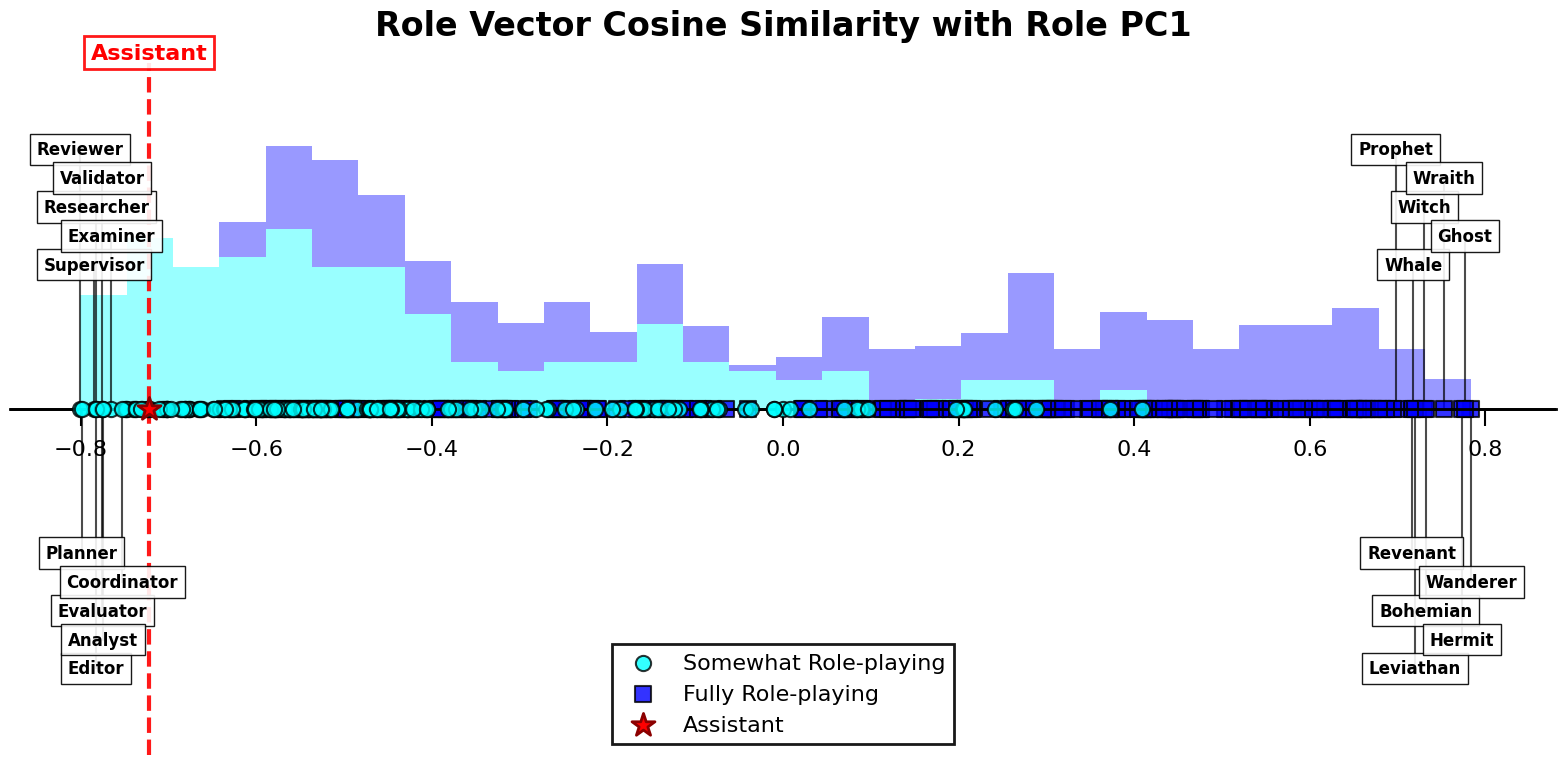

In [17]:
def plot_pc1_role_asst(cosine_similarities, pca_results, role_labels, 
                              assistant_cosine_sim=None, layer=None, figsize=(16, 8), 
                              show_histogram=False):
    """
    Create a poster-optimized projection plot with clear labeling of extremes.
    
    Parameters:
    - cosine_similarities: array of cosine similarity values to plot
    - pca_results: dict with 'vectors' containing 'pos_2' and 'pos_3' for role type detection
    - role_labels: list of role names
    - assistant_cosine_sim: optional scalar cosine similarity value for assistant
    - layer: layer number for title
    - figsize: figure size tuple
    - show_histogram: whether to include histogram subplot
    """
    
    # Set poster-friendly style
    plt.style.use('default')
    sns.set_palette("colorblind")
    
    # Configure for poster readability
    plt.rcParams.update({
        'font.size': 18,
        'axes.titlesize': 24,
        'axes.labelsize': 20,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16,
        'lines.linewidth': 3,
        'axes.linewidth': 2,
        'grid.linewidth': 1.5,
        'patch.linewidth': 2
    })
    
    # Use cosine similarities directly as projections
    projections = cosine_similarities
    
    # Determine colors and markers based on role types using pca_results vectors
    has_pos2 = 'pos_2' in pca_results.get('vectors', {})
    if has_pos2:
        n_pos_2 = len(pca_results['vectors']['pos_2'])
    
    # Create figure
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    
    # Main plot: scatter along x-axis only (y=0)
    y_pos = np.zeros_like(projections)  # All points at y=0
    
    # Store legend elements
    legend_elements = []
    
    if has_pos2:
        # Plot each type separately 
        n_pos_2 = len(pca_results['vectors']['pos_2'])
        
        # Plot fully role-playing FIRST (so they're underneath)
        ax1.scatter(projections[n_pos_2:], y_pos[n_pos_2:], 
                   c='#0000ff', marker='s', s=120, alpha=0.8,
                   edgecolors='black', linewidth=1.5, zorder=2)
        
        # Plot somewhat role-playing SECOND (so they're on top)
        ax1.scatter(projections[:n_pos_2], y_pos[:n_pos_2], 
                   c='#00ffff', marker='o', s=120, alpha=0.8, 
                   edgecolors='black', linewidth=1.5, zorder=3)
        
        # Add legend elements
        legend_elements = [
            plt.scatter([], [], c='#00ffff', marker='o', s=120, alpha=0.8,
                       edgecolors='black', linewidth=1.5, label='Somewhat Role-playing'),
            plt.scatter([], [], c='#0000ff', marker='s', s=120, alpha=0.8,
                       edgecolors='black', linewidth=1.5, label='Fully Role-playing')
        ]
    else:
        ax1.scatter(projections, y_pos, c='#0000ff', marker='o', s=120, 
                   alpha=0.8, edgecolors='black', linewidth=1.5, zorder=3)
        
        # Add legend element
        legend_elements = [
            plt.scatter([], [], c='#0000ff', marker='o', s=120, alpha=0.8,
                       edgecolors='black', linewidth=1.5, label='Roles')
        ]
    
    # Add Assistant position if provided
    if assistant_cosine_sim is not None:
        # Add vertical line at assistant position
        ax1.axvline(x=assistant_cosine_sim, color='red', linestyle='--', 
                   linewidth=3, alpha=0.9, zorder=2)
        
        # Highlight the assistant point with different styling
        ax1.scatter([assistant_cosine_sim], [0], c='red', marker='*', s=300, 
                   alpha=1.0, edgecolors='darkred', linewidth=2, zorder=4)
        
        # Add assistant text label
        ax1.text(assistant_cosine_sim, 0.6, 'Assistant', 
                ha='center', va='bottom', fontsize=16, fontweight='bold',
                color='red', bbox=dict(boxstyle="square,pad=0.3", facecolor='white', 
                edgecolor='red', alpha=0.9))
        
        # Add assistant to legend
        legend_elements.append(
            plt.scatter([], [], c='red', marker='*', s=300, alpha=1.0,
                       edgecolors='darkred', linewidth=2, label='Assistant')
        )

    # Add histogram overlay on the same plot
    if show_histogram:
        # Create histogram data
        hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Scale histogram heights to fit nicely (adjust scale factor as needed)
        hist_scale = 0.15  # This controls how tall the histogram bars are
        scaled_heights = hist_counts * hist_scale
        
        # Plot histogram bars with transparency
        if has_pos2:
            # For two types, create separate histograms
            n_pos_2 = len(pca_results['vectors']['pos_2'])
            hist1, _ = np.histogram(projections[:n_pos_2], bins=bin_edges, density=True)
            hist2, _ = np.histogram(projections[n_pos_2:], bins=bin_edges, density=True)
            
            # Plot stacked bars
            ax1.bar(bin_centers, hist1 * hist_scale, width=bin_width, 
                alpha=0.4, color='#00ffff', edgecolor='none', zorder=1)
            ax1.bar(bin_centers, hist2 * hist_scale, width=bin_width, 
                bottom=hist1 * hist_scale, alpha=0.4, color='#0000ff', 
                edgecolor='none', zorder=1)
        else:
            ax1.bar(bin_centers, scaled_heights, width=bin_width, 
                alpha=0.3, color='lightblue', edgecolor='none', zorder=1)
        
        # Update y-limits to accommodate histogram
        ax1.set_ylim(-0.6, max(0.6, scaled_heights.max() + 0.1))
    
    # Identify and label extremes (no need to exclude assistant since it's separate)
    sorted_indices = np.argsort(projections)
    low_extreme_indices = sorted_indices[:10]
    high_extreme_indices = sorted_indices[-10:]
    extreme_indices = list(low_extreme_indices) + list(high_extreme_indices)
    
    # Create more varied y-positions for labels to avoid overlap
    label_y_positions = []
    # Positions above and below the x-axis
    high_positions = [0.45, 0.25, 0.35, 0.4, 0.3, 0.45, 0.25, 0.35, 0.4, 0.3]
    low_positions = [-0.25, -0.45, -0.35, -0.4, -0.3, -0.25, -0.45, -0.35, -0.4, -0.3]
    
    # Alternate high-low pattern for all extremes
    total_extremes = len(extreme_indices)
    for i in range(total_extremes):
        if i % 2 == 0:
            label_y_positions.append(high_positions[i // 2])
        else:
            label_y_positions.append(low_positions[i // 2])
    
    # Add labels for extremes
    for i, idx in enumerate(extreme_indices):
        label = role_labels[idx].replace(" (Somewhat RP)", "").replace(" (Fully RP)", "")
        x_pos = projections[idx]
        y_label = label_y_positions[i]
        
        # Draw leader line
        ax1.plot([x_pos, x_pos], [0.0, y_label], 'k-', alpha=0.7, linewidth=1.5, zorder=1)
        
        # Add text label with background box
        text = ax1.text(x_pos, y_label, label, ha='center', va='center', 
                       fontsize=12, fontweight='bold', zorder=4)
        
        # Add white background with border (square instead of rounded)
        text.set_bbox(dict(boxstyle="square,pad=0.4", facecolor='white', 
                          edgecolor='black', alpha=0.9, linewidth=1))
    
    # Remove all spines (box around plot) except x-axis
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # Keep x-axis spine and make it cross-like
    ax1.spines['bottom'].set_position('zero')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
    
    # Customize tick parameters
    ax1.tick_params(axis='x', length=12, width=1.5, pad=10)  # Shorter ticks, more padding
    ax1.tick_params(axis='y', length=0, width=0)  # Remove y-axis ticks completely
    
    # Remove grid lines
    ax1.grid(False)
    ax1.set_ylim(-0.6, 0.6)
    
    # Set symmetric x-axis range
    max_abs = max(abs(projections.min()), abs(projections.max()))
    ax1.set_xlim(-max_abs * 1.1, max_abs * 1.1)
    
    ax1.set_ylabel('')
    ax1.set_yticks([])
    
    # Add legend
    ax1.legend(handles=legend_elements, loc='lower center', frameon=True, 
              fancybox=False, shadow=False, framealpha=0.9, 
              facecolor='white', edgecolor='black', fontsize=16)
    
    # Title
    title = "Role Vector Cosine Similarity with Role PC1"
    ax1.set_title(title, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_pc1_role_asst(cosine_sims, pca_results, role_labels, 
                        assistant_cosine_sim=asst_cosine_sim, layer=22, show_histogram=True)

## Role PC1 vs other PCs

In [30]:
pca_transformed = pca_results['pca_transformed']
print(pca_transformed.shape) # samples, components

# each column is the component

(448, 448)


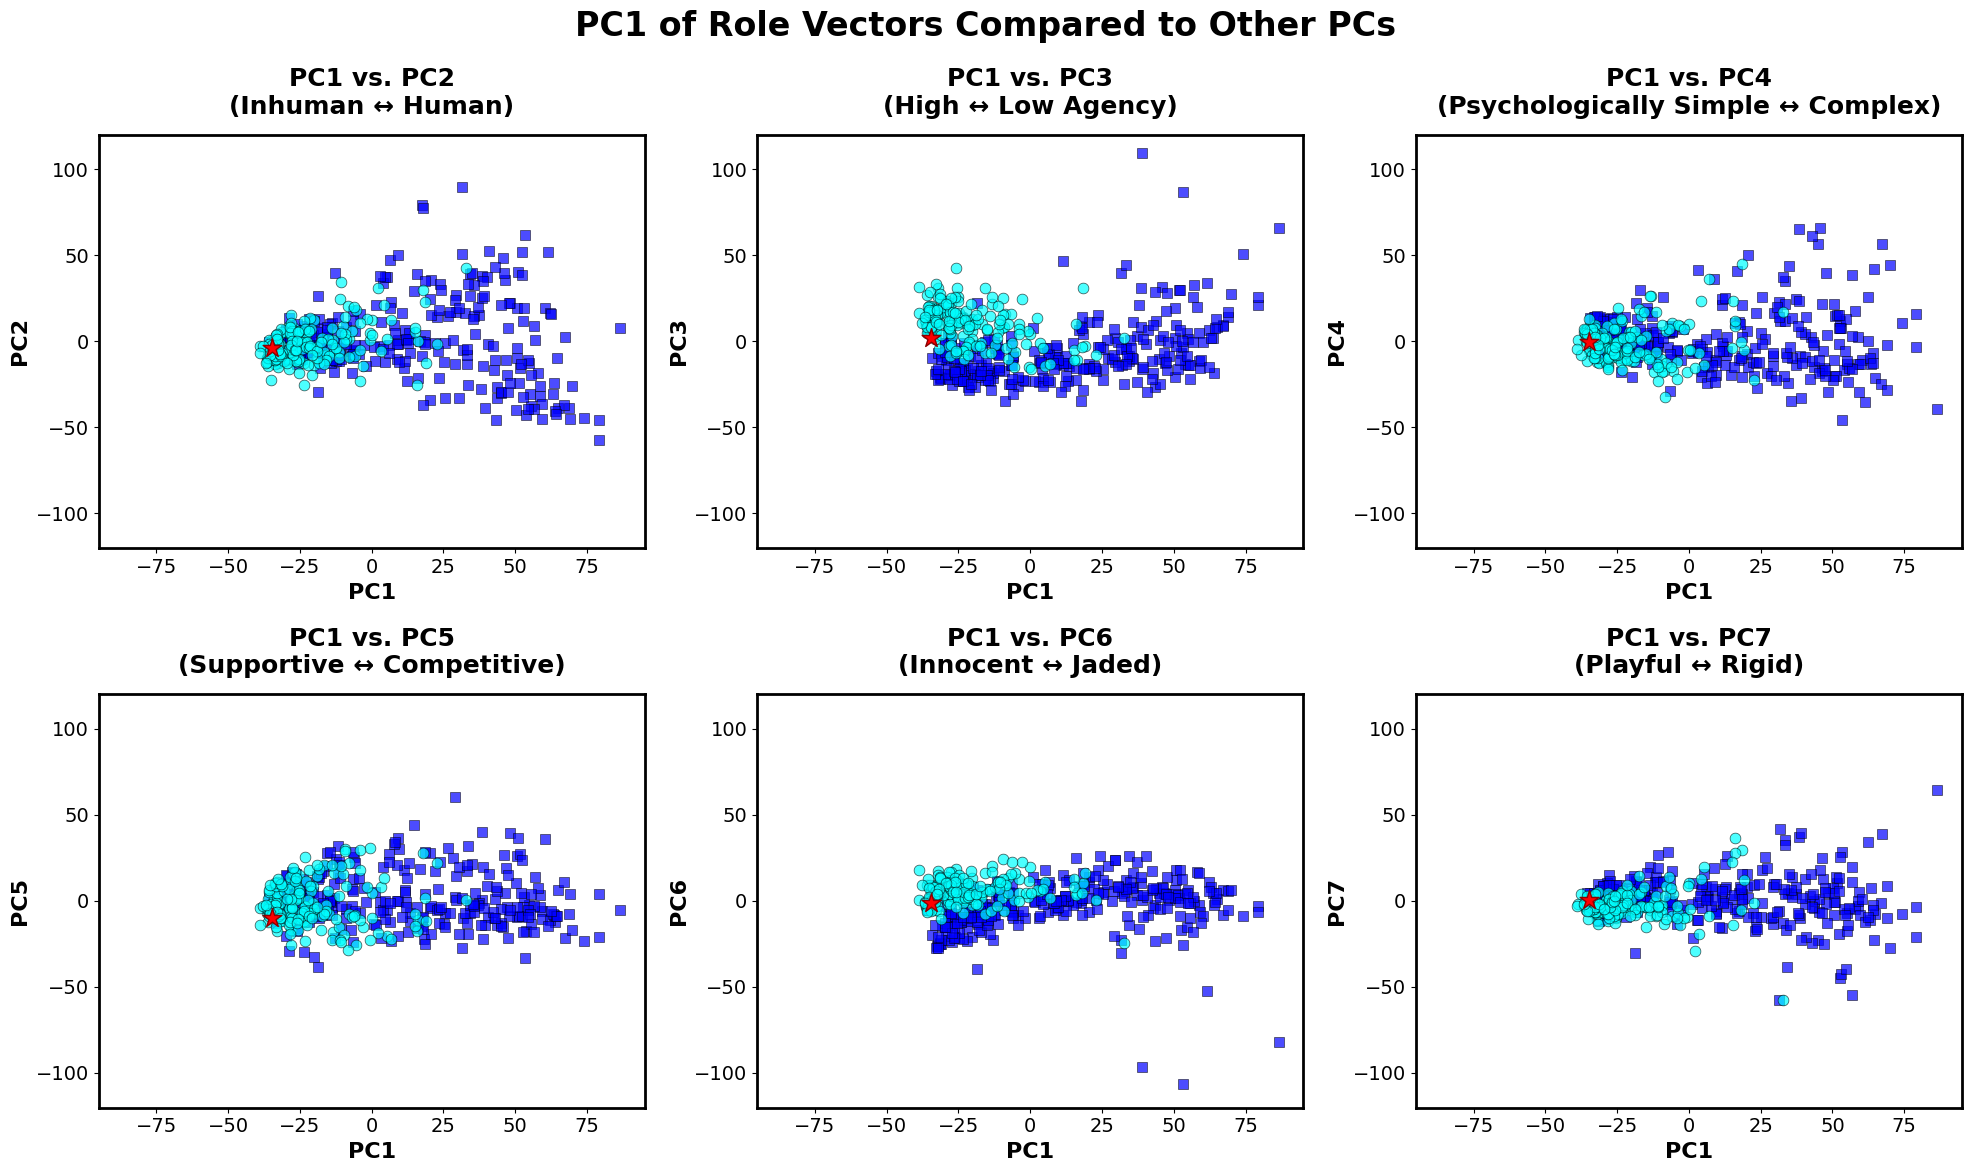

In [39]:

def plot_pc1_vs_others_poster(pca_transformed, asst_projected, role_labels, 
                             figsize=(20, 12)):
    """
    Create a poster-optimized 2x3 scatter plot showing PC1 vs PC2-7.
    
    Parameters:
    - pca_transformed: PCA-transformed data array
    - asst_projected: Assistant projection array  
    - role_labels: list of role names
    - figsize: figure size tuple
    """
    
    # Set poster-friendly style
    plt.style.use('default')
    sns.set_palette("colorblind")
    
    # Configure for poster readability
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 16,
        'lines.linewidth': 2,
        'axes.linewidth': 2,
        'grid.linewidth': 1
    })
    
    # PC interpretations
    pc_names = [
        "Assistant-like ↔ Role-Playing", 
        "Inhuman ↔ Human", 
        "High ↔ Low Agency", 
        "Psychologically Simple ↔ Complex", 
        "Supportive ↔ Competitive", 
        "Innocent ↔ Jaded", 
        "Playful ↔ Rigid"
    ]
    
    # Separate data by role type
    fully_rp_indices = []
    somewhat_rp_indices = []
    
    for i, label in enumerate(role_labels):
        if "(Fully RP)" in label:
            fully_rp_indices.append(i)
        elif "(Somewhat RP)" in label or "Somewhat RP" in label:
            somewhat_rp_indices.append(i)
        else:
            fully_rp_indices.append(i)  # default
    
    # PC1 values for x-axis
    pc1_values = pca_transformed[:, 0]
    
    # Calculate consistent y-axis range for all PC2-7
    y_values_all = pca_transformed[:, 1:7]  # PC2-7
    y_max = np.max(np.abs(y_values_all))
    y_range = [-y_max * 1.1, y_max * 1.1]  # Add 10% padding, symmetric around 0
    
    # Calculate consistent x-axis range
    x_max = np.max(np.abs(pc1_values))
    x_range = [-x_max * 1.1, x_max * 1.1]
    
    # Create 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle('PC1 of Role Vectors Compared to Other PCs', 
                fontsize=24, fontweight='bold', y=0.98)
    

    
    # Create scatter plots for PC2-7 vs PC1
    for i in range(6):  # PC2 to PC7
        pc_idx = i + 1  # PC2 starts at index 1
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        pc_values = pca_transformed[:, pc_idx]
        
        # Add Fully Role-Playing points (plot first so they're underneath)
        if fully_rp_indices:
            ax.scatter(pc1_values[fully_rp_indices], pc_values[fully_rp_indices],
                      c='#0000ff', marker='s', s=60, alpha=0.7, 
                      edgecolors='black', linewidth=0.5,
                      label='Fully Role-Playing' if i == 0 else "")
        
        # Add Somewhat Role-Playing points (plot second so they're on top)
        if somewhat_rp_indices:
            ax.scatter(pc1_values[somewhat_rp_indices], pc_values[somewhat_rp_indices],
                      c='#00ffff', marker='o', s=60, alpha=0.7,
                      edgecolors='black', linewidth=0.5,
                      label='Somewhat Role-Playing' if i == 0 else "")
        
        # Add Assistant projection point
        ax.scatter(asst_projected[0, 0], asst_projected[0, pc_idx],
                  c='red', marker='*', s=200, alpha=1.0,
                  edgecolors='darkred', linewidth=1,
                  label='Assistant' if i == 0 else "", zorder=5)
        
        # Styling
        # ax.grid(True, alpha=0.3)
        # ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
        # ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
        
        # Set ranges
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        
        # Labels
        ax.set_xlabel('PC1', fontweight='bold')
        ax.set_ylabel(f'PC{pc_idx + 1}', fontweight='bold')
        
        # Title with PC interpretation
        title = f'PC1 vs. PC{pc_idx + 1}'
        subtitle = f'({pc_names[pc_idx]})'
        ax.set_title(f'{title}\n{subtitle}', fontweight='bold', pad=15)
        
        # if i == 0:
            # ax.legend(bbox_to_anchor=(3.6, 1.0), loc='upper left', 
            #          framealpha=0.9, edgecolor='black',
            #          fancybox=False, shadow=False)
    
    # Adjust layout - keep plots in good position
    plt.tight_layout()
    
    
    return fig


fig = plot_pc1_vs_others_poster(pca_transformed, asst_projected, role_labels)
plt.show()

## Role PC1 cosine similarity with traits

In [18]:
trait_dir = "traits_240"
# load in pca results
rp_basis = torch.load('/root/git/persona-subspace/roles/data/pca_240/layer22_pos23_pc1.pt', weights_only=False)
trait_results = torch.load(f"/workspace/{trait_dir}/pca/layer{layer}_pos-neg50.pt", weights_only=False)
trait_names = trait_results['traits']['pos_neg_50']


In [19]:
trait_tensor = trait_results['vectors']['pos_neg_50']
trait_layer_vectors = trait_tensor[:, layer, :].float().numpy()

In [20]:
rp_basis_scaled = trait_results['scaler'].transform(rp_basis.reshape(1, -1))
scaled_trait_vectors = trait_results['scaler'].transform(trait_layer_vectors)

normalized_trait_vectors = scaled_trait_vectors / np.linalg.norm(scaled_trait_vectors, axis=1, keepdims=True)
normalized_rp_basis = rp_basis_scaled.flatten() / np.linalg.norm(rp_basis_scaled.flatten())

print(f"Normalized trait vectors shape: {normalized_trait_vectors.shape}")
print(f"Normalized role PC1 shape: {normalized_rp_basis.shape}")

# Compute cosine similarities (dot products of normalized vectors)
cosine_similarities = normalized_trait_vectors @ normalized_rp_basis
cosine_similarities = cosine_similarities * -1

Normalized trait vectors shape: (239, 4608)
Normalized role PC1 shape: (4608,)


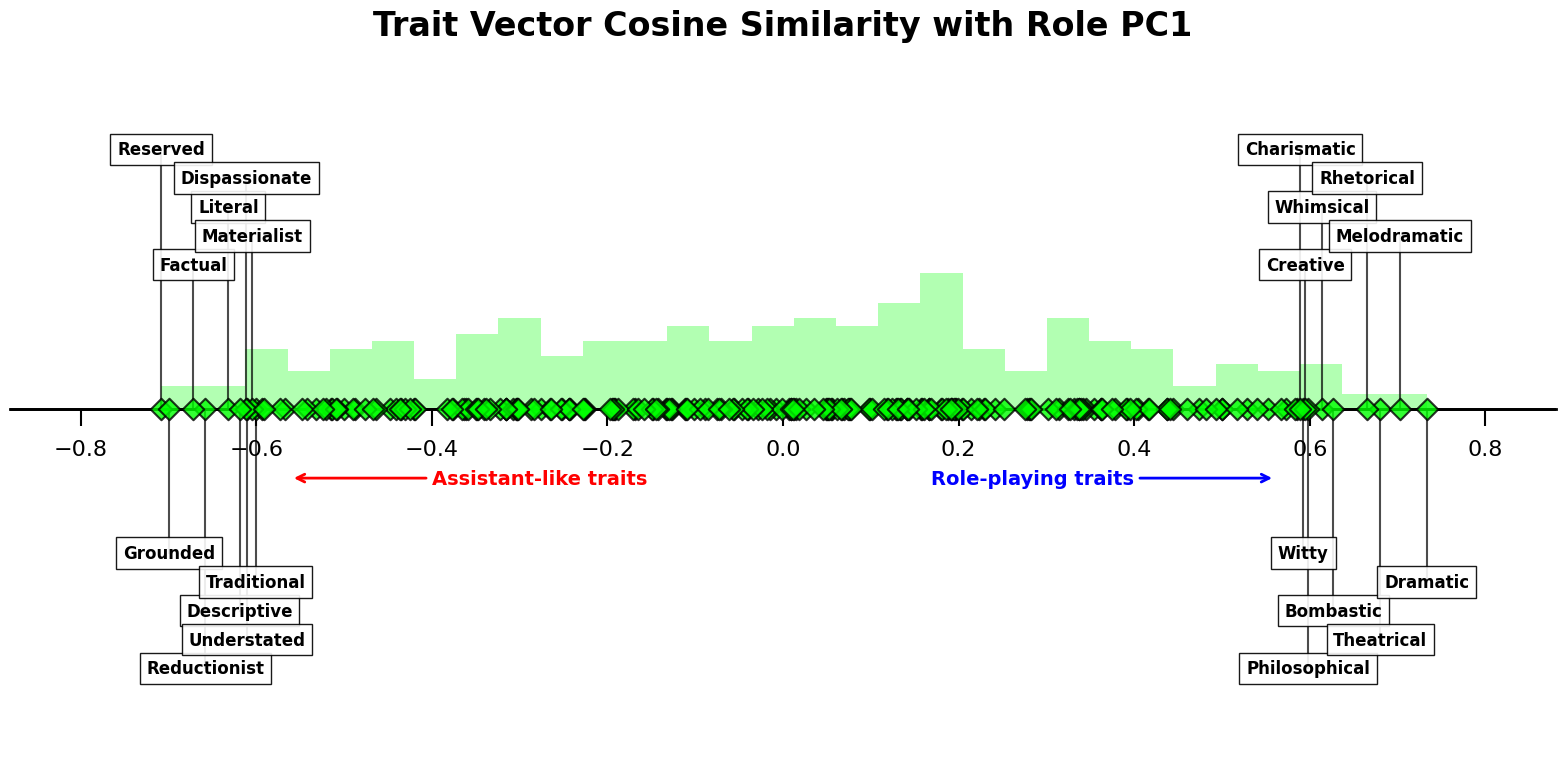

In [29]:
def plot_cosine_similarity_poster(cosine_correlations, role_cosine_sim, trait_names, layer=None, 
                                 figsize=(16, 8), n_top=10, show_histogram=False):
    """
    Create a poster-optimized cosine similarity plot matching the PC1 plot style.
    
    Parameters:
    - cosine_correlations: array of cosine similarity values
    - trait_names: list of trait names
    - layer: layer number for title
    - figsize: figure size tuple
    - n_top: number of extreme traits to label on each end
    - show_histogram: whether to include histogram overlay
    """
    
    # Set poster-friendly style
    plt.style.use('default')
    sns.set_palette("colorblind")
    
    # Configure for poster readability
    plt.rcParams.update({
        'font.size': 18,
        'axes.titlesize': 24,
        'axes.labelsize': 20,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 18,
        'lines.linewidth': 3,
        'axes.linewidth': 2,
        'grid.linewidth': 1.5,
        'patch.linewidth': 2
    })
    
    # Create figure
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    
    # Main plot: scatter along x-axis only (y=0)
    y_pos = np.zeros_like(cosine_correlations)  # All points at y=0
    
    # Plot all points as green diamonds
    ax1.scatter(cosine_correlations, y_pos, c='#00ff00', marker='D', s=120, 
               alpha=0.8, edgecolors='black', linewidth=1.5, zorder=3)
    
    # Add histogram overlay on the same plot
    if show_histogram:
        # Create histogram data
        hist_counts, bin_edges = np.histogram(cosine_correlations, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Scale histogram heights to fit nicely (adjust scale factor as needed)
        hist_scale = 0.15  # This controls how tall the histogram bars are
        scaled_heights = hist_counts * hist_scale
        
        # Plot histogram bars with transparency
        ax1.bar(bin_centers, scaled_heights, width=bin_width, 
                alpha=0.3, color='lime', edgecolor='none', zorder=1)
        
        # Update y-limits to accommodate histogram
        ax1.set_ylim(-0.6, max(0.6, scaled_heights.max() + 0.1))
    else:
        ax1.set_ylim(-0.6, 0.6)
    
    # Identify and label extremes
    sorted_indices = np.argsort(cosine_correlations)
    low_extreme_indices = sorted_indices[:n_top]
    high_extreme_indices = sorted_indices[-n_top:]
    extreme_indices = list(low_extreme_indices) + list(high_extreme_indices)
    
    # Create more varied y-positions for labels to avoid overlap
    label_y_positions = []
    # Positions above and below the x-axis
    high_positions = [0.45, 0.25, 0.35, 0.4, 0.3, 0.45, 0.25, 0.35, 0.4, 0.3]
    low_positions = [-0.25, -0.45, -0.35, -0.4, -0.3, -0.25, -0.45, -0.35, -0.4, -0.3]
    
    # Alternate high-low pattern for all extremes
    total_extremes = len(extreme_indices)
    for i in range(total_extremes):
        if i % 2 == 0:
            label_y_positions.append(high_positions[i // 2])
        else:
            label_y_positions.append(low_positions[i // 2])
    
    # Add labels for extremes
    for i, idx in enumerate(extreme_indices):
        x_pos = cosine_correlations[idx]
        # Capitalize the trait name
        label = trait_names[idx].title()
        y_label = label_y_positions[i]
        
        # Draw leader line
        ax1.plot([x_pos, x_pos], [0.0, y_label], 'k-', alpha=0.7, linewidth=1.5, zorder=1)
        
        # Add text label with background box
        text = ax1.text(x_pos, y_label, label, ha='center', va='center', 
                       fontsize=12, fontweight='bold', zorder=4)
        
        # Add white background with border (square instead of rounded)
        text.set_bbox(dict(boxstyle="square,pad=0.4", facecolor='white', 
                          edgecolor='black', alpha=0.9, linewidth=1))
    
    # Remove all spines (box around plot) except x-axis
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # Keep x-axis spine and make it cross-like
    ax1.spines['bottom'].set_position('zero')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
    
    # Customize tick parameters
    ax1.tick_params(axis='x', length=12, width=1.5, pad=10)  # Shorter ticks, more padding
    ax1.tick_params(axis='y', length=0, width=0)  # Remove y-axis ticks completely
    
    # Remove grid lines
    ax1.grid(False)
    
    # Set symmetric x-axis range
    max_abs = max(abs(role_cosine_sim.min()), abs(role_cosine_sim.max()))
    ax1.set_xlim(-max_abs * 1.1, max_abs * 1.1)

     # Add directional annotations
    # Left side: Assistant-like traits (red arrow pointing left)
    left_x = -max_abs * 0.7  # Position at 70% of the way to the left edge
    ax1.annotate('Assistant-like traits', xy=(left_x, -0.12), xytext=(left_x + max_abs * 0.2, -0.12),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=14, fontweight='bold', color='red', ha='left', va='center')
    
    # Right side: Role-playing traits (blue arrow pointing right)
    right_x = max_abs * 0.7  # Position at 70% of the way to the right edge
    ax1.annotate('Role-playing traits', xy=(right_x, -0.12), xytext=(right_x - max_abs * 0.2, -0.12),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                fontsize=14, fontweight='bold', color='blue', ha='right', va='center')
    
    
    ax1.set_ylabel('')
    ax1.set_yticks([])
    
    # Add legend
    # legend_elements = [
    #     plt.scatter([], [], c='#2ca02c', marker='D', s=120, alpha=0.8, 
    #                edgecolors='black', linewidth=1.5, label='Traits')
    # ]
    # ax1.legend(handles=legend_elements, loc='upper right', frameon=True, 
    #           fancybox=False, shadow=False, framealpha=0.9, 
    #           facecolor='white', edgecolor='black', fontsize=16)
    
    # Title
    title = "Trait Vector Cosine Similarity with Role PC1"
    ax1.set_title(title, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_cosine_similarity_poster(cosine_similarities, cosine_sims, trait_names, 
                                  layer=22, show_histogram=True)